<a href="https://colab.research.google.com/github/Ivoyaa/MIPT_simpsons_resnet50/blob/main/simpsons_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

#### Роман_Ельченков_271194579

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.7.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.8.1+cu101)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip
!ls -1

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
characters_illustration.png
gdrive
label_encoder.pkl
sample_data
sample_submission.csv
testset
train


In [ ]:
!ls train
!ls testset

simpsons_dataset
testset


In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Nov 23 10:08:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL  import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),                            
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomAffine(degrees=40, scale=(.9, 1.1)),                            
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=7, verbose=True)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, sch)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            sch.step(metrics=val_loss)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
from torchvision import models
resnet50 = models.resnet50(pretrained = True).to(DEVICE)
#print(resnet50)

In [ ]:
ct = 0
for child in resnet50.children():
  ct += 1
  if ct < 8:
    for param in child.parameters():
        param.requires_grad = False   
resnet50.fc = nn.Linear(2048, 42).to(DEVICE)

Запустим обучение сети.

In [ ]:

val_dataset = SimpsonsDataset(val_files, mode='val') 
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=resnet50, epochs=45, batch_size=64)

epoch:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


loss 0.9933355252023973


epoch:   2%|▏         | 1/45 [04:51<3:33:58, 291.77s/it]


Epoch 001 train_loss: 0.9933     val_loss 0.5438 train_acc 0.7525 val_acc 0.8592
loss 0.8552529517196


epoch:   4%|▍         | 2/45 [09:43<3:29:00, 291.64s/it]


Epoch 002 train_loss: 0.8553     val_loss 0.5180 train_acc 0.7829 val_acc 0.8687
loss 0.4670794760013767


epoch:   7%|▋         | 3/45 [14:33<3:23:59, 291.41s/it]


Epoch 003 train_loss: 0.4671     val_loss 0.4179 train_acc 0.8769 val_acc 0.8964
loss 0.38455117268485317


epoch:   9%|▉         | 4/45 [19:24<3:18:56, 291.13s/it]


Epoch 004 train_loss: 0.3846     val_loss 0.3571 train_acc 0.9003 val_acc 0.9100
loss 0.3373587273402505


epoch:  11%|█         | 5/45 [24:14<3:13:47, 290.68s/it]


Epoch 005 train_loss: 0.3374     val_loss 0.4379 train_acc 0.9118 val_acc 0.8842
loss 0.30526875926777164


epoch:  13%|█▎        | 6/45 [29:04<3:08:57, 290.72s/it]


Epoch 006 train_loss: 0.3053     val_loss 0.3053 train_acc 0.9199 val_acc 0.9230
loss 0.26130407864489036


epoch:  16%|█▌        | 7/45 [33:56<3:04:16, 290.95s/it]


Epoch 007 train_loss: 0.2613     val_loss 0.3312 train_acc 0.9293 val_acc 0.9175
loss 0.2397993716853076


epoch:  18%|█▊        | 8/45 [38:48<2:59:39, 291.35s/it]


Epoch 008 train_loss: 0.2398     val_loss 0.3120 train_acc 0.9362 val_acc 0.9257
loss 0.2269409664254772


epoch:  20%|██        | 9/45 [43:39<2:54:47, 291.33s/it]


Epoch 009 train_loss: 0.2269     val_loss 0.3056 train_acc 0.9395 val_acc 0.9220
loss 0.2023408068023056


epoch:  22%|██▏       | 10/45 [48:29<2:49:41, 290.90s/it]


Epoch 010 train_loss: 0.2023     val_loss 0.2584 train_acc 0.9459 val_acc 0.9370
loss 0.18583095956816098


epoch:  24%|██▍       | 11/45 [53:20<2:44:45, 290.74s/it]


Epoch 011 train_loss: 0.1858     val_loss 0.2998 train_acc 0.9515 val_acc 0.9282
loss 0.16995176788237004


epoch:  27%|██▋       | 12/45 [58:09<2:39:37, 290.23s/it]


Epoch 012 train_loss: 0.1700     val_loss 0.3225 train_acc 0.9536 val_acc 0.9249
loss 0.16067140806530172


epoch:  29%|██▉       | 13/45 [1:02:59<2:34:52, 290.38s/it]


Epoch 013 train_loss: 0.1607     val_loss 0.3091 train_acc 0.9566 val_acc 0.9257
loss 0.15668892347855934


epoch:  31%|███       | 14/45 [1:07:48<2:29:47, 289.92s/it]


Epoch 014 train_loss: 0.1567     val_loss 0.2751 train_acc 0.9585 val_acc 0.9383
loss 0.14510948627929002


epoch:  33%|███▎      | 15/45 [1:12:37<2:24:44, 289.48s/it]


Epoch 015 train_loss: 0.1451     val_loss 0.2504 train_acc 0.9609 val_acc 0.9364
loss 0.1399599664702166


epoch:  36%|███▌      | 16/45 [1:17:27<2:20:02, 289.74s/it]


Epoch 016 train_loss: 0.1400     val_loss 0.2451 train_acc 0.9622 val_acc 0.9427
loss 0.12059793853886101


epoch:  38%|███▊      | 17/45 [1:22:16<2:15:03, 289.40s/it]


Epoch 017 train_loss: 0.1206     val_loss 0.2548 train_acc 0.9679 val_acc 0.9429
loss 0.12209775704085823


epoch:  40%|████      | 18/45 [1:27:05<2:10:09, 289.26s/it]


Epoch 018 train_loss: 0.1221     val_loss 0.2365 train_acc 0.9655 val_acc 0.9488
loss 0.1119141732538606


epoch:  42%|████▏     | 19/45 [1:31:53<2:05:16, 289.11s/it]


Epoch 019 train_loss: 0.1119     val_loss 0.2326 train_acc 0.9692 val_acc 0.9498
loss 0.10006536773474013


epoch:  44%|████▍     | 20/45 [1:36:44<2:00:35, 289.41s/it]


Epoch 020 train_loss: 0.1001     val_loss 0.2526 train_acc 0.9731 val_acc 0.9450
loss 0.09716962345850469


epoch:  47%|████▋     | 21/45 [1:41:35<1:55:58, 289.94s/it]


Epoch 021 train_loss: 0.0972     val_loss 0.2287 train_acc 0.9731 val_acc 0.9473
loss 0.10579762546427696


epoch:  49%|████▉     | 22/45 [1:46:28<1:51:31, 290.95s/it]


Epoch 022 train_loss: 0.1058     val_loss 0.2545 train_acc 0.9699 val_acc 0.9433
loss 0.10410451842552045


epoch:  51%|█████     | 23/45 [1:51:19<1:46:39, 290.91s/it]


Epoch 023 train_loss: 0.1041     val_loss 0.2471 train_acc 0.9726 val_acc 0.9469
loss 0.08788822925890379


epoch:  53%|█████▎    | 24/45 [1:56:11<1:41:56, 291.28s/it]


Epoch 024 train_loss: 0.0879     val_loss 0.2049 train_acc 0.9744 val_acc 0.9553
loss 0.06360423738515729


epoch:  56%|█████▌    | 25/45 [2:01:03<1:37:09, 291.45s/it]


Epoch 025 train_loss: 0.0636     val_loss 0.2397 train_acc 0.9820 val_acc 0.9488
loss 0.07730372253686989


epoch:  58%|█████▊    | 26/45 [2:05:53<1:32:11, 291.12s/it]


Epoch 026 train_loss: 0.0773     val_loss 0.2481 train_acc 0.9781 val_acc 0.9484
loss 0.0704781999535675


epoch:  60%|██████    | 27/45 [2:10:46<1:27:28, 291.58s/it]


Epoch 027 train_loss: 0.0705     val_loss 0.2591 train_acc 0.9794 val_acc 0.9438
loss 0.06958637478156214


epoch:  62%|██████▏   | 28/45 [2:15:38<1:22:39, 291.76s/it]


Epoch 028 train_loss: 0.0696     val_loss 0.2150 train_acc 0.9814 val_acc 0.9591
loss 0.07446966239026538


epoch:  64%|██████▍   | 29/45 [2:20:28<1:17:41, 291.36s/it]


Epoch 029 train_loss: 0.0745     val_loss 0.2105 train_acc 0.9801 val_acc 0.9561
loss 0.07588914237958945


epoch:  67%|██████▋   | 30/45 [2:25:20<1:12:50, 291.36s/it]


Epoch 030 train_loss: 0.0759     val_loss 0.2156 train_acc 0.9802 val_acc 0.9547
loss 0.05533474717694746


epoch:  69%|██████▉   | 31/45 [2:30:10<1:07:52, 290.91s/it]


Epoch 031 train_loss: 0.0553     val_loss 0.2189 train_acc 0.9845 val_acc 0.9555
loss 0.06285101864830417


epoch:  71%|███████   | 32/45 [2:34:59<1:02:56, 290.53s/it]

Epoch    32: reducing learning rate of group 0 to 1.0000e-04.

Epoch 032 train_loss: 0.0629     val_loss 0.2050 train_acc 0.9822 val_acc 0.9570
loss 0.02669875957527387


epoch:  73%|███████▎  | 33/45 [2:39:50<58:08, 290.69s/it]


Epoch 033 train_loss: 0.0267     val_loss 0.1835 train_acc 0.9927 val_acc 0.9666
loss 0.01978341489482657


epoch:  76%|███████▌  | 34/45 [2:44:40<53:14, 290.44s/it]


Epoch 034 train_loss: 0.0198     val_loss 0.1701 train_acc 0.9948 val_acc 0.9683
loss 0.015044496138034552


epoch:  78%|███████▊  | 35/45 [2:49:31<48:24, 290.43s/it]


Epoch 035 train_loss: 0.0150     val_loss 0.1720 train_acc 0.9962 val_acc 0.9681
loss 0.01174472415250494


epoch:  80%|████████  | 36/45 [2:54:20<43:31, 290.20s/it]


Epoch 036 train_loss: 0.0117     val_loss 0.1812 train_acc 0.9970 val_acc 0.9687
loss 0.012847672202245303


epoch:  82%|████████▏ | 37/45 [2:59:10<38:39, 289.95s/it]


Epoch 037 train_loss: 0.0128     val_loss 0.1902 train_acc 0.9962 val_acc 0.9669
loss 0.011208506906858918


epoch:  84%|████████▍ | 38/45 [3:03:59<33:48, 289.83s/it]


Epoch 038 train_loss: 0.0112     val_loss 0.2005 train_acc 0.9965 val_acc 0.9643
loss 0.011500630105305606


epoch:  87%|████████▋ | 39/45 [3:08:48<28:57, 289.53s/it]


Epoch 039 train_loss: 0.0115     val_loss 0.1921 train_acc 0.9970 val_acc 0.9690
loss 0.011458762832730306


epoch:  89%|████████▉ | 40/45 [3:13:37<24:06, 289.36s/it]


Epoch 040 train_loss: 0.0115     val_loss 0.2060 train_acc 0.9972 val_acc 0.9668
loss 0.00852054936461094


epoch:  91%|█████████ | 41/45 [3:18:26<19:16, 289.23s/it]


Epoch 041 train_loss: 0.0085     val_loss 0.1838 train_acc 0.9977 val_acc 0.9681
loss 0.009701950709752407


epoch:  93%|█████████▎| 42/45 [3:23:14<14:26, 288.92s/it]

Epoch    42: reducing learning rate of group 0 to 1.0000e-05.

Epoch 042 train_loss: 0.0097     val_loss 0.1940 train_acc 0.9968 val_acc 0.9710
loss 0.0076304570799354135


epoch:  96%|█████████▌| 43/45 [3:28:03<09:37, 288.77s/it]


Epoch 043 train_loss: 0.0076     val_loss 0.1956 train_acc 0.9979 val_acc 0.9685
loss 0.0075942609277166884


epoch:  98%|█████████▊| 44/45 [3:32:51<04:48, 288.71s/it]


Epoch 044 train_loss: 0.0076     val_loss 0.1845 train_acc 0.9976 val_acc 0.9702
loss 0.008257866499729715


epoch: 100%|██████████| 45/45 [3:37:41<00:00, 290.25s/it]


Epoch 045 train_loss: 0.0083     val_loss 0.1986 train_acc 0.9974 val_acc 0.9717


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)   

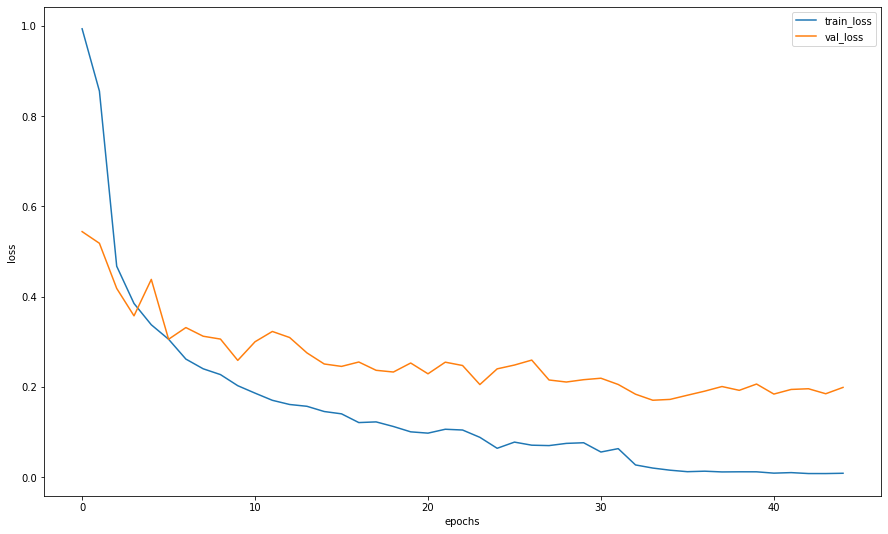

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss") 
plt.legend(loc='best')
plt.xlabel("epochs")   
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet50, ex_img.unsqueeze(0))

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet50, imgs)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


### Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet50, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('resnet50_baseline.csv', index=False)
# файл появится у вас на гугл диске

In [ ]:
! ls

characters_illustration.png  resnet50_baseline.csv  testset
gdrive			     sample_data	    train
label_encoder.pkl	     sample_submission.csv
